# This Notebook Contains Code that Tests the XGBoost Algorithm to find the best hyperparameters and tests feature importance

### This code is taken from https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ and adapted to our needs... It is a comprehensive guide and is very useful to our cause

In [14]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV  #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train = pd.read_csv('./data/aggregate_201007.csv')
target = 'reuse'
IDcol = 'project'
train.dropna()
train.pop('maven_release')
train.pop('release')

0            1.0.0
1              0.7
2           2.5.23
3           2.5.23
4           2.4.20
          ...     
238    1.1.0.Final
239           1.58
240           1.13
241          2.6.1
242        1.4.3-1
Name: release, Length: 243, dtype: object

##### This function is used to fit the model while using cross validation as well, could be used later on for different models, however as of now it is exclusice to XGB

In [40]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='mlogloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print(alg)                
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

##### Tuning tree based parameters

In [16]:
def f(x):
    if x['maven_reuse'] < 42: return 0
    elif x['maven_reuse'] < 106 and x['maven_reuse']>=42: return 1
    else: return 2

train['reuse'] = train.apply(f, axis=1)

In [17]:
train.head()

,project,maven_reuse,class_count,cbo_sum,cbo_average,cbo_stdev,cbo_median,cbo_min,cbo_max,nosi_sum,...,wmc_median,wmc_min,wmc_max,mathOperationsQty_sum,mathOperationsQty_average,mathOperationsQty_stdev,mathOperationsQty_median,mathOperationsQty_min,mathOperationsQty_max,reuse
0,aalto-xml,23.0,158,962.0,6.088608,6.154466,4.0,0.0,35.0,1135.0,...,14.5,0.0,1163.0,1660.0,10.506329,29.268523,2.0,0.0,231.0,0
1,airline,48.0,135,552.0,4.088889,4.931572,3.0,0.0,29.0,224.0,...,1.0,0.0,52.0,69.0,0.511111,1.976982,0.0,0.0,14.0,1
2,akka-actor,208.0,2965,17280.0,5.827993,7.032081,3.0,0.0,39.0,6752.0,...,2.0,0.0,630.0,1348.0,0.454637,4.703745,0.0,0.0,215.0,2
3,akka-slf4j,135.0,2965,17280.0,5.827993,7.032081,3.0,0.0,39.0,6752.0,...,2.0,0.0,630.0,1348.0,0.454637,4.703745,0.0,0.0,215.0,2
4,akka-testkit,258.0,2338,14078.0,6.049850,7.039021,3.0,0.0,38.0,5558.0,...,2.0,0.0,359.0,955.0,0.410400,2.490832,0.0,0.0,67.0,2


<AxesSubplot:>

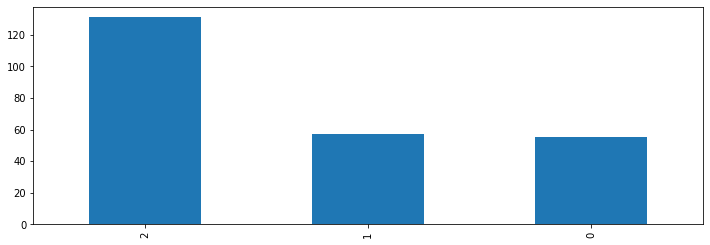

In [18]:
train.reuse.value_counts().plot(kind='bar')

In [19]:
train.pop('maven_reuse')


0        23.0
1        48.0
2       208.0
3       135.0
4       258.0
        ...  
238    2085.0
239     138.0
240      21.0
241      10.0
242      18.0
Name: maven_reuse, Length: 243, dtype: float64

In [20]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Columns: 267 entries, project to reuse
dtypes: float64(264), int64(2), object(1)
memory usage: 507.0+ KB


In [22]:
train['reuse'].size

243

In [23]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]

train[predictors].size


64395

In [24]:
train[predictors].head()

,class_count,cbo_sum,cbo_average,cbo_stdev,cbo_median,cbo_min,cbo_max,nosi_sum,nosi_average,nosi_stdev,...,wmc_stdev,wmc_median,wmc_min,wmc_max,mathOperationsQty_sum,mathOperationsQty_average,mathOperationsQty_stdev,mathOperationsQty_median,mathOperationsQty_min,mathOperationsQty_max
0,158,962.0,6.088608,6.154466,4.0,0.0,35.0,1135.0,7.183544,29.247209,...,158.906812,14.5,0.0,1163.0,1660.0,10.506329,29.268523,2.0,0.0,231.0
1,135,552.0,4.088889,4.931572,3.0,0.0,29.0,224.0,1.659259,5.519522,...,10.006615,1.0,0.0,52.0,69.0,0.511111,1.976982,0.0,0.0,14.0
2,2965,17280.0,5.827993,7.032081,3.0,0.0,39.0,6752.0,2.277234,5.673473,...,31.052490,2.0,0.0,630.0,1348.0,0.454637,4.703745,0.0,0.0,215.0
3,2965,17280.0,5.827993,7.032081,3.0,0.0,39.0,6752.0,2.277234,5.673473,...,31.052490,2.0,0.0,630.0,1348.0,0.454637,4.703745,0.0,0.0,215.0
4,2338,14078.0,6.049850,7.039021,3.0,0.0,38.0,5558.0,2.388483,5.622734,...,29.221798,2.0,0.0,359.0,955.0,0.410400,2.490832,0.0,0.0,67.0


In [27]:
train[target].shape

(243,)

In [28]:
train[predictors].shape

(243, 265)

In [41]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softprob',
 num_class = 3,
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

[07:44:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:44:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:44:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters a

TypeError: 'NoneType' object is not callable

##### Tuning max depth and min_child_weight

In [42]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob',num_class=3, nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='neg_log_loss',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.best_params_, gsearch1.best_score_, gsearch1.cv_results_

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[07:48:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




({'max_depth': 7, 'min_child_weight': 5},
 -1.263115080072367,
 {'mean_fit_time': array([1.04342966, 0.96900659, 0.99141445, 1.36430459, 1.17474437,
         1.19740953, 1.52388473, 1.26495895, 1.15464754, 1.52351556,
         1.31278839, 1.13266306]),
  'std_fit_time': array([0.02319718, 0.02600045, 0.03284106, 0.09618033, 0.04167889,
         0.11852837, 0.03288633, 0.07708528, 0.12651061, 0.01918688,
         0.05433089, 0.04929654]),
  'mean_score_time': array([0.01093163, 0.01064463, 0.01095157, 0.01134963, 0.01102886,
         0.01121202, 0.01139708, 0.01114941, 0.01193242, 0.0116292 ,
         0.01153121, 0.01044803]),
  'std_score_time': array([0.00050076, 0.00030019, 0.00021023, 0.00040451, 0.0002142 ,
         0.00057005, 0.00065886, 0.00082329, 0.00021914, 0.00037513,
         0.00035261, 0.00084086]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     

##### Tuning Gamma

In [ ]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])

#### Tune subsample and colsample_bytree

In [ ]:
modelfit(gsearch3.best_estimator_, train, predictors)
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

##### Tunin regularization parameters

In [ ]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

In [ ]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

In [ ]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors)

##### Reducing learning rate and increasing number of trees (be careful here because this may lead to overtraining)

In [ ]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)